### Импорты

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Далее в работе будет использоваться временной ряд - данные о погоде.

### Данные

In [4]:
df = pd.read_csv('rainfall.csv', index_col=['date'], parse_dates=['date'])
df.head()

,mean_rainfall
date,
1990-01-01,1.613
1990-01-11,1.557
1990-01-21,2.219
1990-02-01,4.788
1990-02-11,6.510


In [7]:
df = df.resample('M').mean().dropna()
df.head()

,mean_rainfall
date,
1990-01-31,1.796333
1990-02-28,5.270333
1990-03-31,9.169667
1990-04-30,16.180333
1990-05-31,78.126333


### Визуализация ряда и предположения о его компонентах

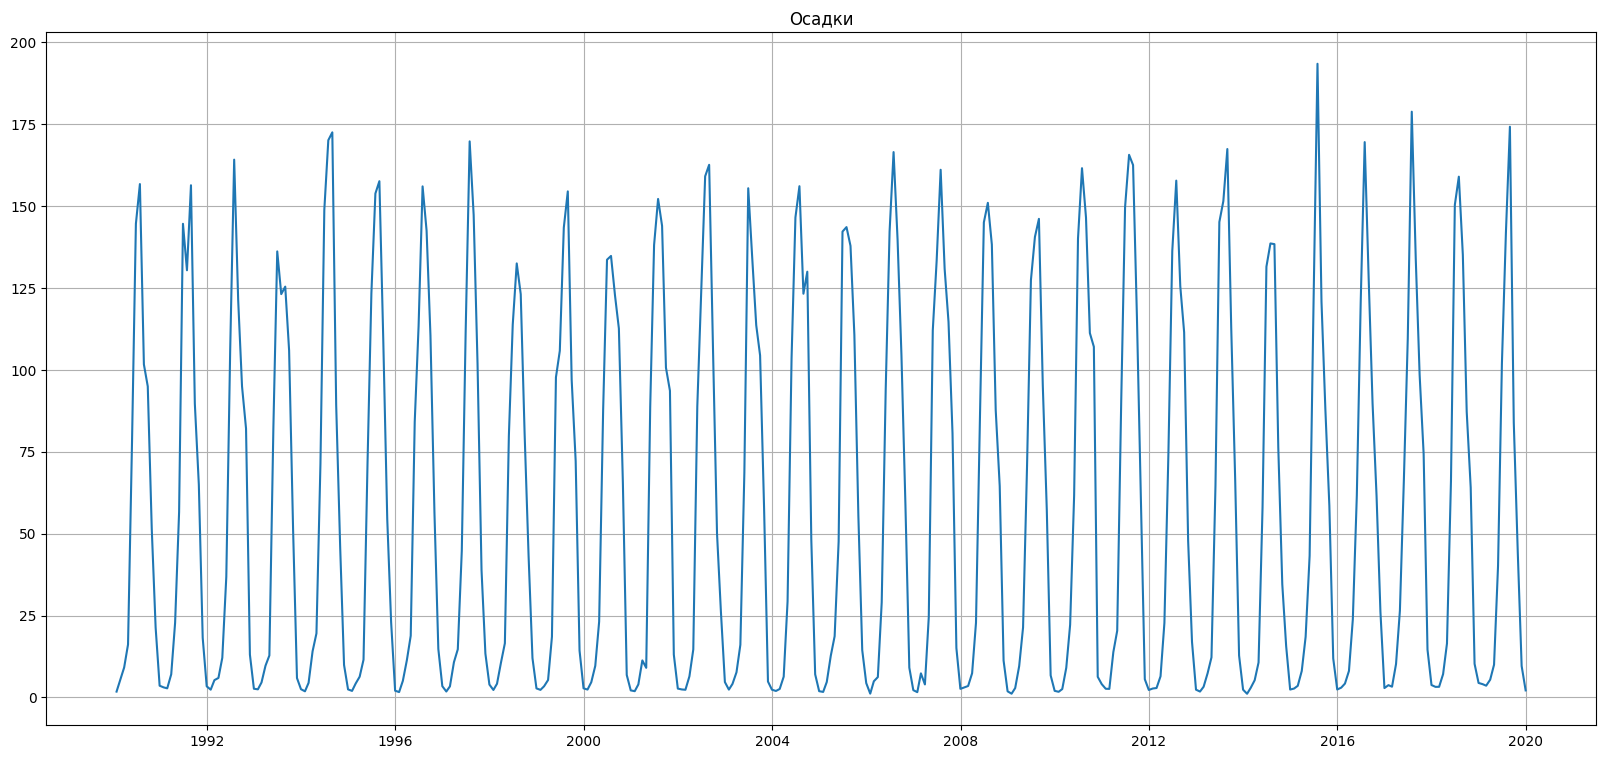

In [18]:
plt.figure(figsize=(20, 9))
plt.plot(df.mean_rainfall)
plt.title('Осадки')
plt.grid(True)
plt.show()

Судя по данной визуализации, наблюдается сезонность(рост осадков вначале года и уменьшение к концу), ряд не стационарен, тренда не наблюдается. 

### train/test split

In [19]:
def train_test_split(df, test_size):

    test_index = int(len(df)*(1-test_size))

    df_train = df.iloc[:test_index]
    df_test = df.iloc[test_index:]

    return df_train, df_test


df_train, df_test = train_test_split(df, test_size=0.3)

### Бейзлайн в виде скользящего среднего

In [30]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(df_train, 5)

106.55699999999999

In [31]:
df_test.head(5)

,mean_rainfall
date,
2010-12-31,4.079667
2011-01-31,2.665667
2011-02-28,2.628000
2011-03-31,13.852000
2011-04-30,20.375333


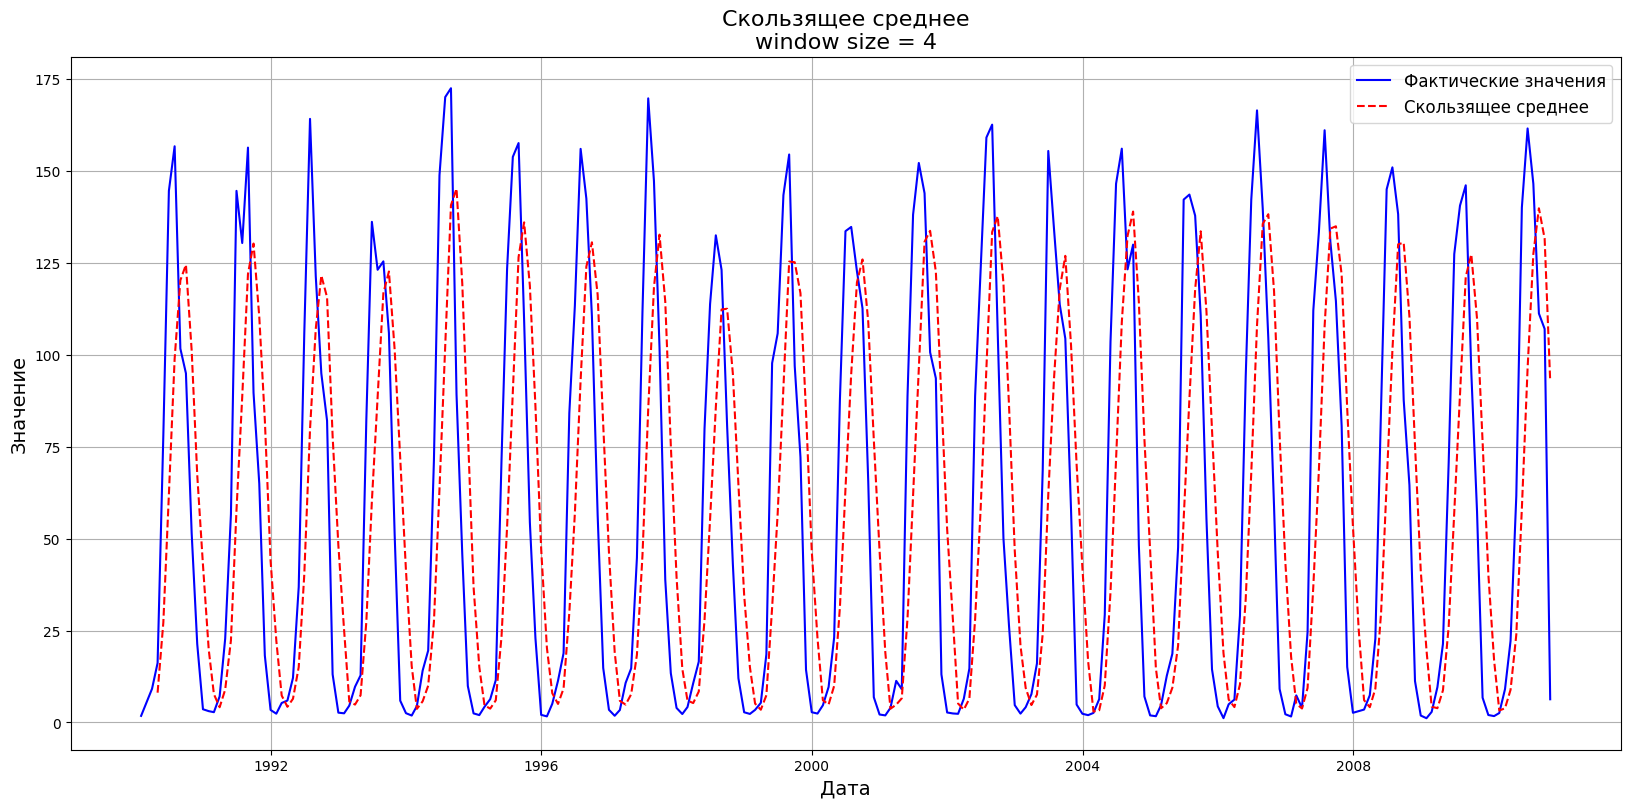

In [42]:
import matplotlib.pyplot as plt

def plot_moving_average(series, window):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(20, 9))
    plt.plot(series.index, series, label='Фактические значения', color='blue')
    plt.plot(rolling_mean.index, rolling_mean, 'r--', label='Скользящее среднее')
    plt.title('Скользящее среднее\nwindow size = {}'.format(window), fontsize=16)
    plt.xlabel('Дата', fontsize=14)
    plt.ylabel('Значение', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_moving_average(df_train, 4)


Для того, чтобы определить качество работы бейзлайна, была рассчитана МАЕ

In [43]:
mean_absolute_error([moving_average(df_train, 4)], df_test.head(1))

88.71700000000001

### Статистическая модель

### Тест Дики-Фуллера 

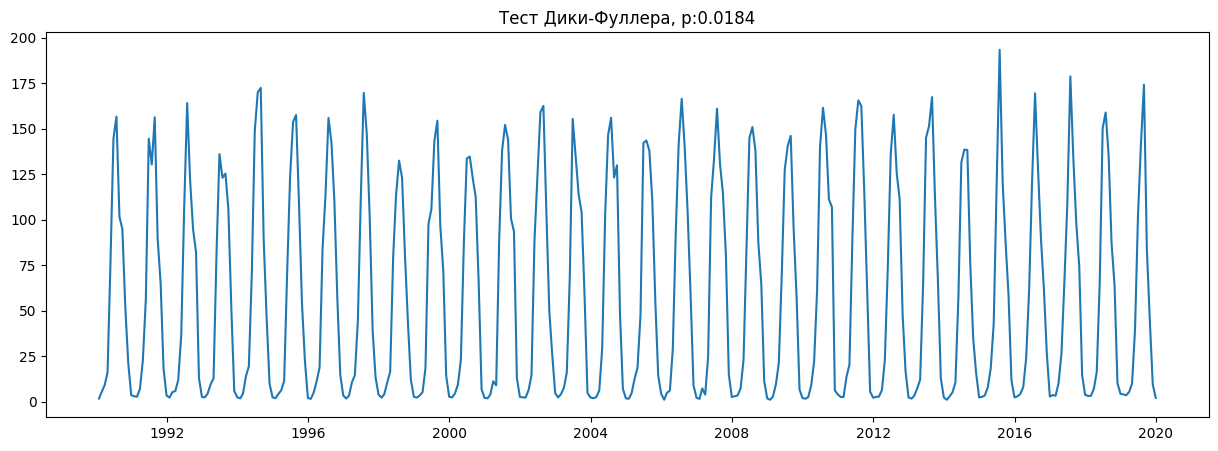

In [46]:
plt.figure(figsize=(15, 5))
plt.plot(df)
plt.title("Тест Дики-Фуллера, p:{}".format(round(sm.tsa.stattools.adfuller(df_train)[1], 4)))
plt.show()

Значение p близко к нулю. Можно сделать вывод, что ряд стационарен. 

### Графики ACF/PACF 

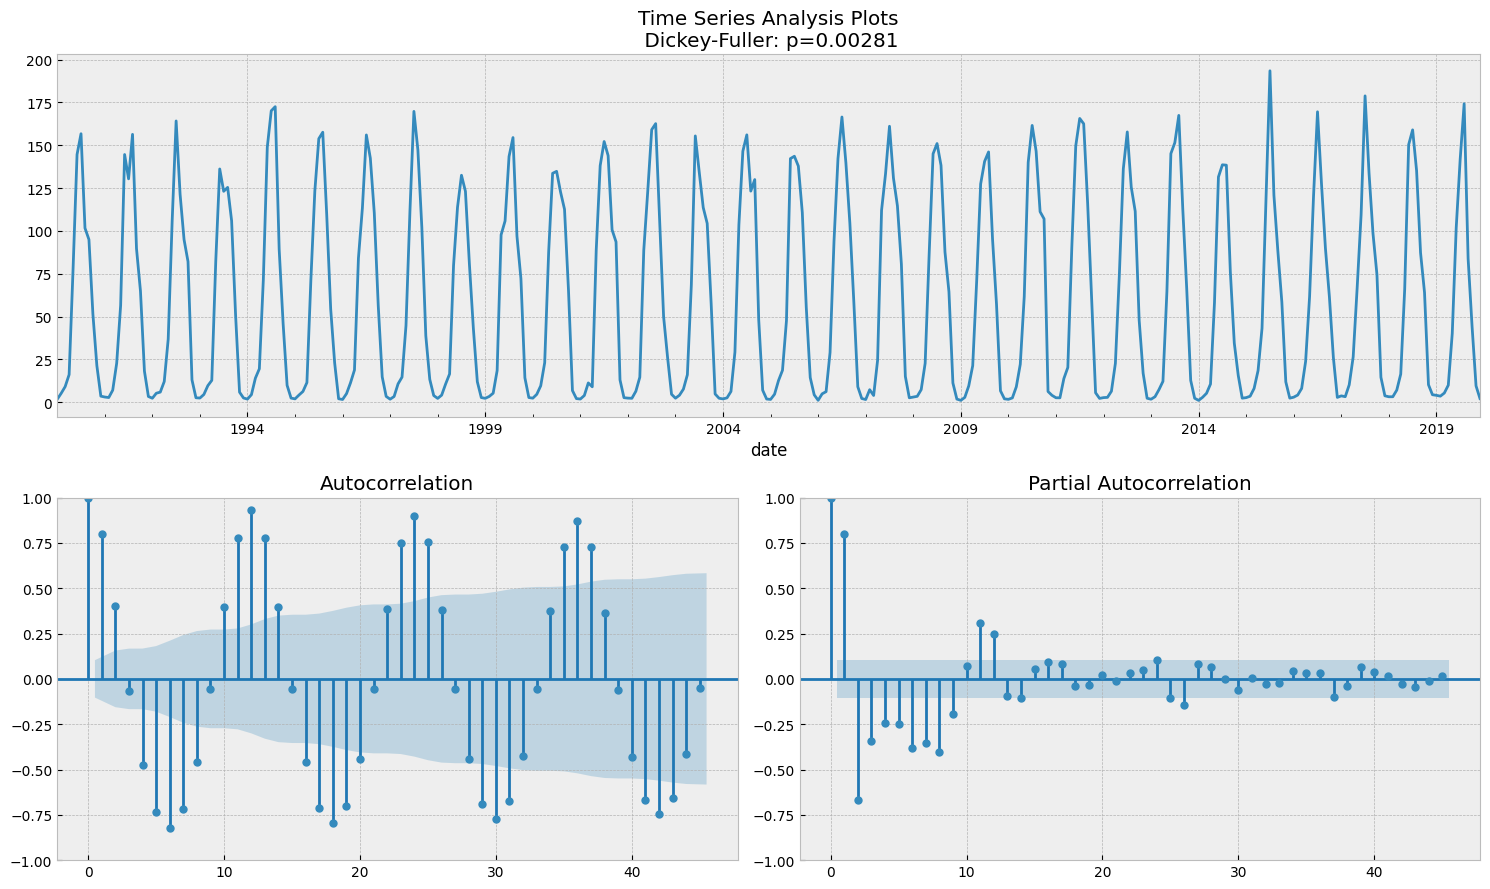

In [50]:
def tsplot(y, lags=None, figsize=(15, 9), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(df.mean_rainfall, lags=45)

Можно сделать вывод, что продолжительность сезонности 12 лагов, то есть 1 год. 

### Классическая модель

In [61]:
data = pd.DataFrame(df.mean_rainfall.copy())
data.columns = ["y"]


In [62]:
for i in range(1, 37):
    data["lag_{}".format(i)] = data.y.shift(i)

### Признаки дня и месяца

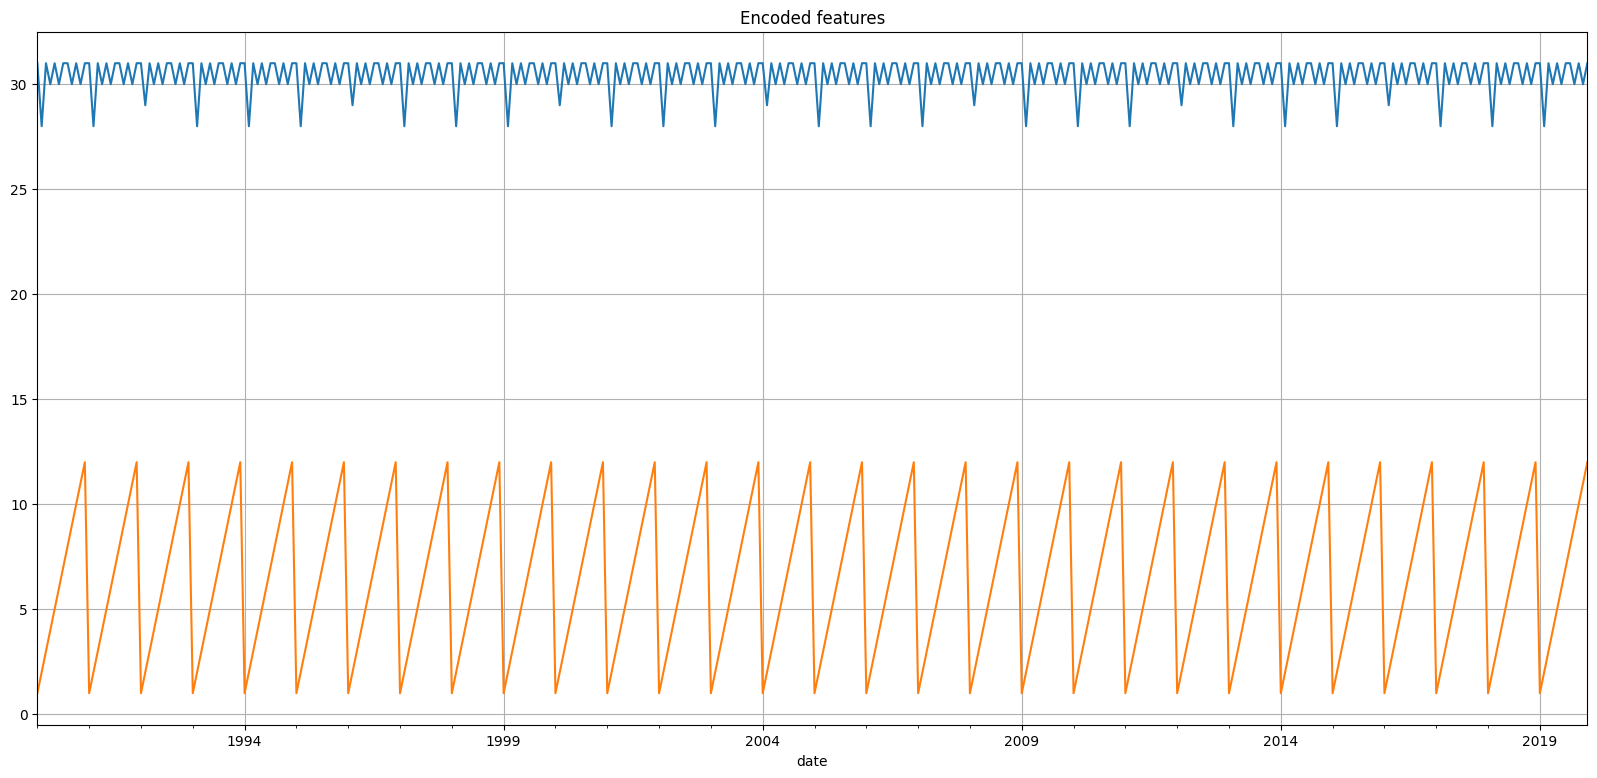

In [66]:
data['day'] = data.index.day
data['month'] = data.index.month
plt.figure(figsize=(20, 9))
plt.title("Encoded features")
data.day.plot()
data.month.plot()
plt.grid(True)

### Обучение модели

### test/train split

In [67]:
def timeseries_train_test_split(X, y, test_size):

    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [68]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [72]:
def plotModelResults(model, X_train=X_train, X_test=X_test):

    prediction = model.predict(X_test)

    plt.figure(figsize=(20, 9))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

In [78]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=7, random_state=45)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, random_state=45)

Визуализация

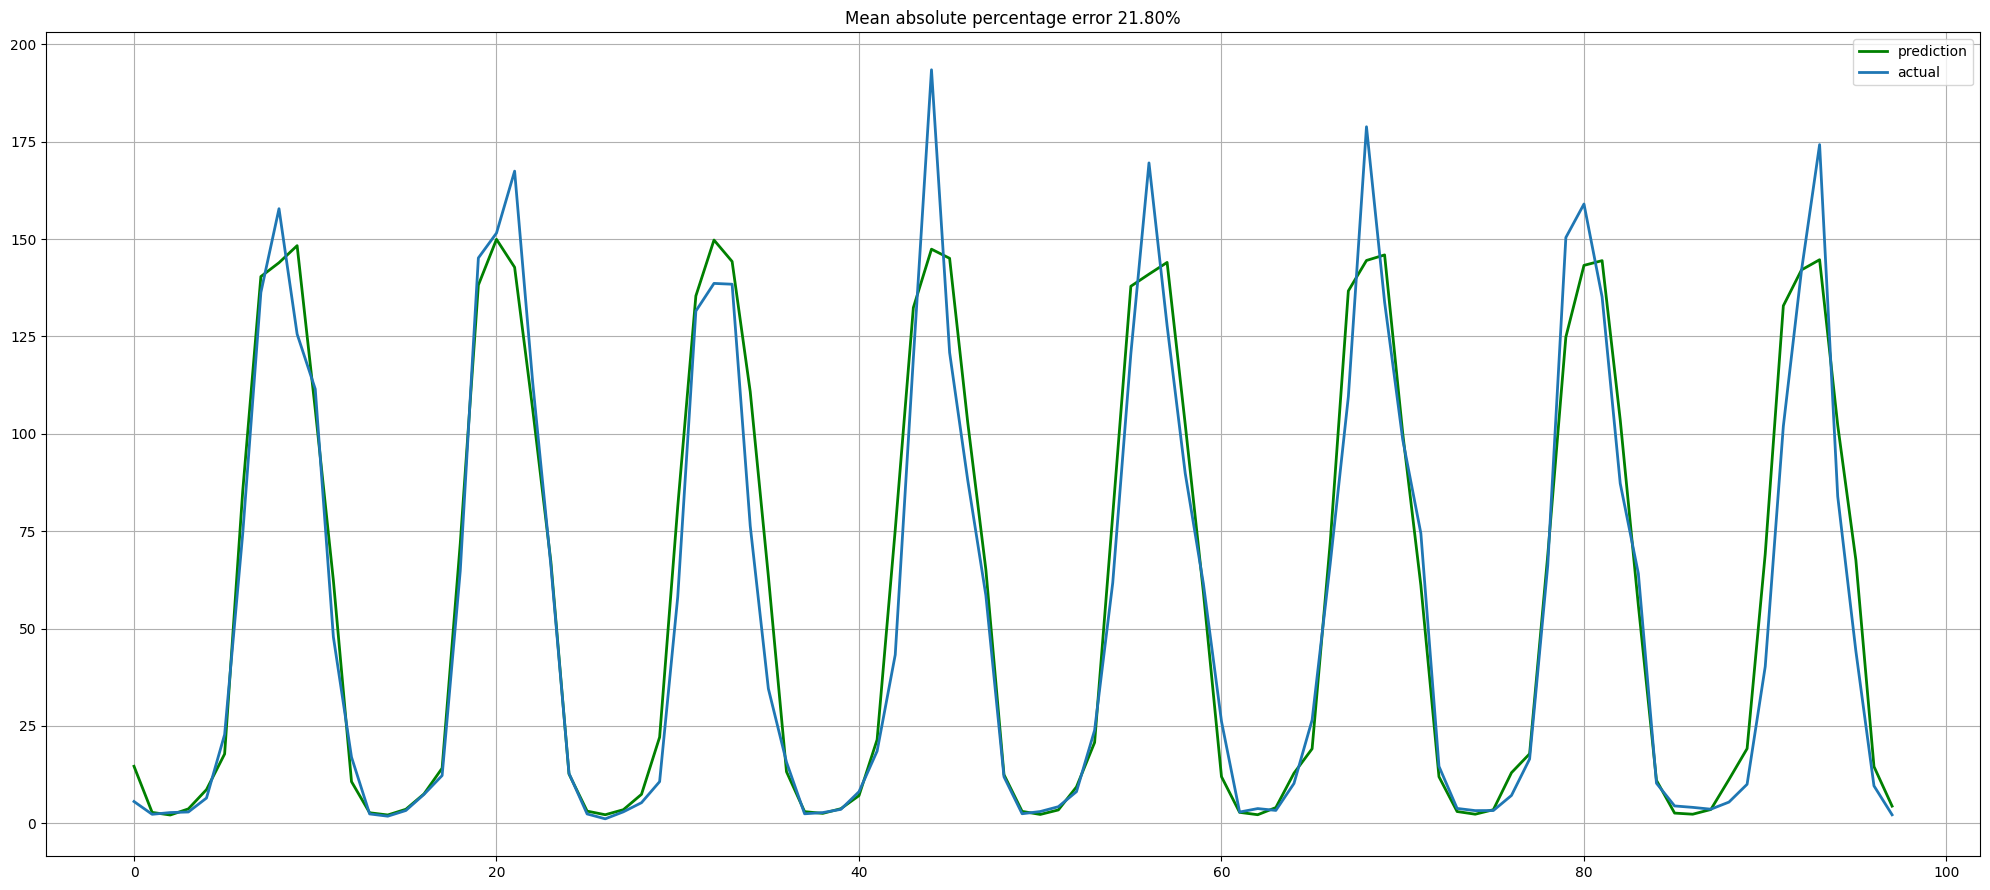

In [79]:
plotModelResults(regr, X_train=X_train, X_test=X_test)

### Интерпретация

permutation importance

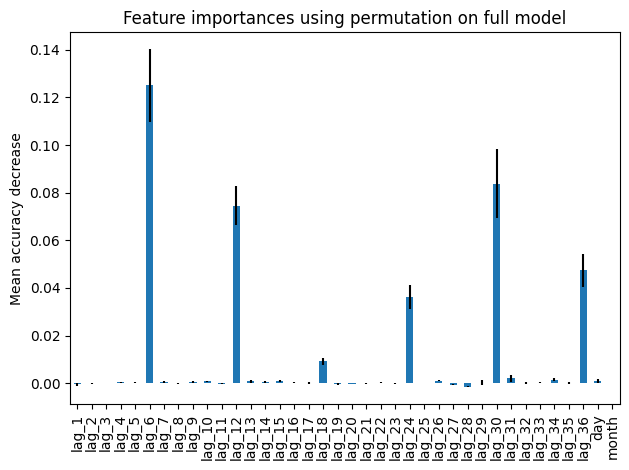

In [80]:
from sklearn.inspection import permutation_importance

importances = permutation_importance(regr, X_test, y_test, n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

lime

In [82]:
from lime import lime_tabular


explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['rings'],
    verbose=True,
    mode='regression',
)
i = 33
exp = explainer.explain_instance(X_test.iloc[i].values, regr.predict, num_features=5)

Intercept 40.56216335416072
Prediction_local [129.53853858]
Right: 144.24742529705298


In [85]:
exp.show_in_notebook(show_table=True)

In [86]:
exp.as_list()

[('lag_6 <= 4.99', 26.766735903987247),
 ('lag_12 > 112.52', 18.584000910084068),
 ('lag_30 <= 5.14', 17.35108126970538),
 ('lag_36 > 112.01', 14.352182236621092),
 ('lag_24 > 112.52', 11.92237490994784)]

Можно сделать вывод, что для анализа данных, лучшими значениями лагов являются 12*n. 